# Code

EV aggregator implementation based on State Space Model.

### EV SSM Class

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ev_ssm import ev_ssm
from ev_ssm import r_agc_sev
from tqdm import tqdm

In [2]:
# --- Replay ---
# Replay EV control signal from recorded data
# Replay 1 hour data may need 0.5 hour
# Replay is not accurate

sse_out = pd.read_csv('sse_out.csv')
sse_out = sse_out.iloc[3200:].reset_index(drop=True)

t0 = sse_out['time'].iloc[0]
sse = ev_ssm(ts=t0, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA")
sse.load_A("Aest.csv")

ev_soc = pd.DataFrame(columns=range(sse_out.shape[0]))
ev_agc = pd.DataFrame(columns=range(sse_out.shape[0]))

for row in tqdm(range(sse_out.shape[0]), desc=f'{sse.name} Replay'):
    sse.run(tf=sse_out.time.iloc[row], Pi=sse_out.Pr.iloc[row],
            is_updateA=False, is_rstate=True,
            is_test=False, disable=True)
    ev_soc[row] = sse.ev.soc
    ev_agc[row] = sse.ev.agc

EVA: ts=10.8889[H], 10000 EVs, Total Q=250.12 MWh
Online 1573, Q=39.56 MWh, SoC=0.9644
Power(MW): Pt=-0.6534, Pc=-0.6534, Pd=-0.0
Ctrl: 0=1464; 1=109; 
EVA: Load A from Aest.csv.
EVA Replay: 100%|██████████| 400/400 [01:55<00:00,  3.47it/s]


(<Figure size 600x300 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [H]', ylabel='Power (MW)'>)

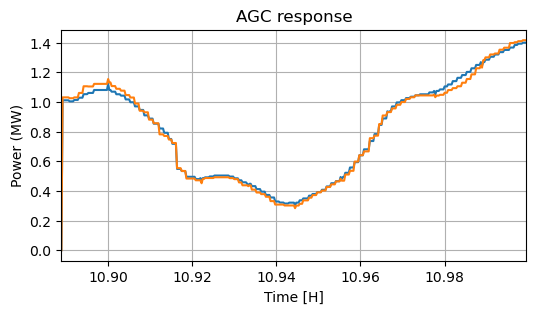

In [3]:
sse.plot_agc()

(<Figure size 600x300 with 2 Axes>,
 <AxesSubplot:title={'center':'EVA'}, xlabel='Time [H]', ylabel='Power (MW)'>)

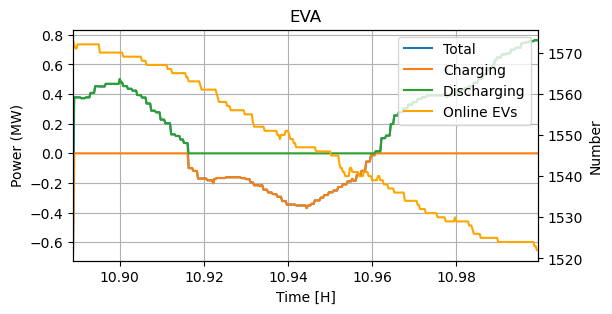

In [5]:
sse.plot()